# Creating nice maps with xarray

xarray basic plotting options are enough to make quick plots, but for your paper's figures you probably want to have more options. Let's look at what xarray can do! NB: For this to work, you need the version of xarray >= 0.16.0

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import xarray as xr
import cmocean

Load the sample dataset and geolon/geolat from static file (without holes on eliminated processors):

In [3]:
dataurl = 'http://35.188.34.63:8080/thredds/dodsC/OM4p5/'

ds = xr.open_dataset(f'{dataurl}/ocean_monthly_z.200301-200712.nc4',
                     chunks={'time':1, 'z_l': 1}, drop_variables=['average_DT', 'average_T1', 'average_T2'], engine='pydap')

In [4]:
grid = xr.open_dataset('./data/ocean_grid_sym_OM4_05.nc')

Now assign the coordinates from the static file:

In [5]:
ds = ds.assign_coords({'geolon': grid['geolon'],
                       'geolat': grid['geolat']})

Select the month and vertical level we want to plot:

In [6]:
sst_plot = ds['thetao'].sel(time='2003-01', z_l=2.5)

## A simple cylindrical equidistant map

This is what a quick SST plot would look like:

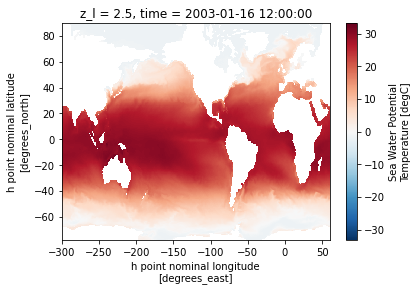

In [7]:
sst_plot.plot()

Not great, right? First xarray infers data limits and a corresponding colormaps and is completely off.
Figure is too small and coordinates are not right (we want geolon/geolat, see getting started notebook).
Let's fix this right now by setting the figure size, limits

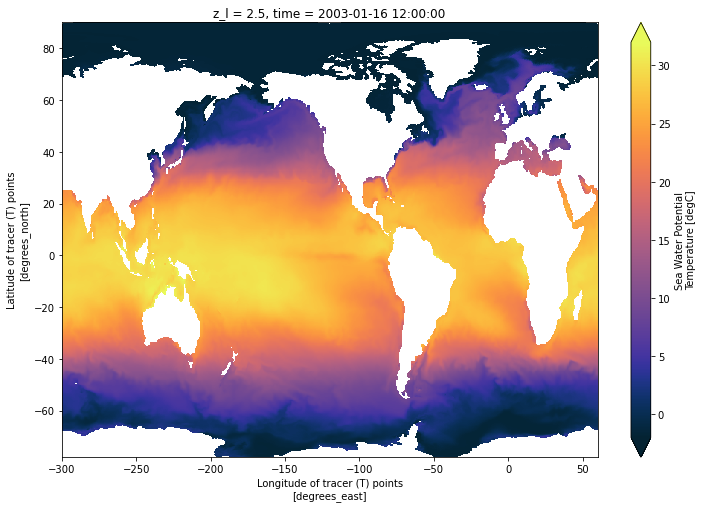

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=[12,8])
sst_plot.plot(x='geolon', y='geolat',
              vmin=-2, vmax=32,
              cmap=cmocean.cm.thermal)

Ok at least now the plot is accurate and can be useful scientifically but we still have a bit of work to make it
publication ready: we're gonna want a real map projection, continents filled in a different color,... In order to do this, we're going to use cartopy projections and change axes attributes:

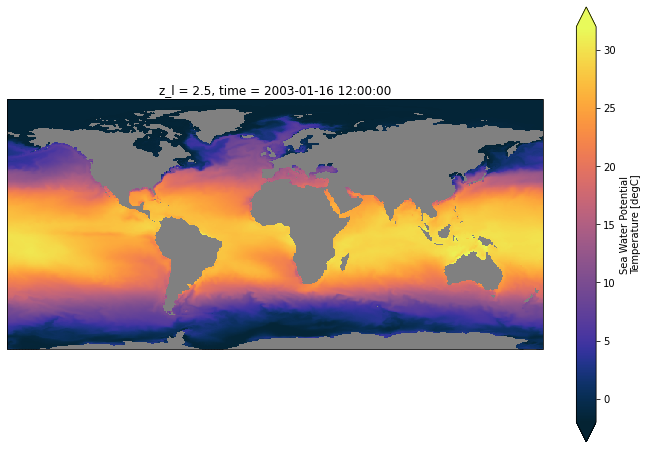

In [9]:
import cartopy.crs as ccrs

subplot_kws=dict(projection=ccrs.PlateCarree(),
                 facecolor='grey')

plt.figure(figsize=[12,8])
sst_plot.plot(x='geolon', y='geolat',
              vmin=-2, vmax=32,
              cmap=cmocean.cm.thermal,
              subplot_kws=subplot_kws,
              transform=ccrs.PlateCarree())

You can pick any projection from the cartopy list but, whichever projection you use, you still have to set 

```python
transform=ccrs.PlateCarree()
```

facecolor can be one of the pre-defined colors ('white', 'w', 'red', 'r', ...) or a RGB triplet (e.g. [0.5, 0.5, 0.5])

Now I don't like the labels xarray puts and I don't have control on the colormaps so I'm going to suppress them and
add them *a posteriori*

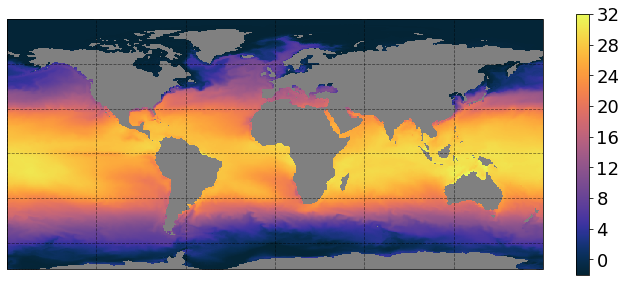

In [10]:
subplot_kws=dict(projection=ccrs.PlateCarree(),
                 facecolor='grey')

plt.figure(figsize=[12,8])
p = sst_plot.plot(x='geolon', y='geolat',
                  vmin=-2, vmax=32,
                  cmap=cmocean.cm.thermal,
                  subplot_kws=subplot_kws,
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False)

# add separate colorbar
cb = plt.colorbar(p, ticks=[0,4,8,12,16,20,24,28,32], shrink=0.6)
cb.ax.tick_params(labelsize=18)

# optional add grid lines
p.axes.gridlines(color='black', alpha=0.5, linestyle='--')

Next step is to add parallels/meridiens and their labels, this gets a little more involved:

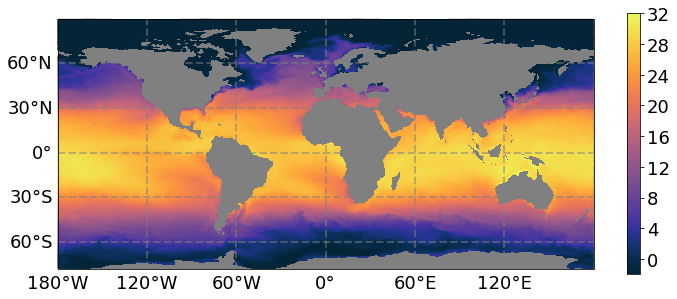

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np

subplot_kws=dict(projection=ccrs.PlateCarree(),
                 facecolor='grey')

plt.figure(figsize=[12,8])
p = sst_plot.plot(x='geolon', y='geolat',
                  vmin=-2, vmax=32,
                  cmap=cmocean.cm.thermal,
                  subplot_kws=subplot_kws,
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False)

# add separate colorbar
cb = plt.colorbar(p, ticks=[0,4,8,12,16,20,24,28,32], shrink=0.6)
cb.ax.tick_params(labelsize=18)

# draw parallels/meridiens and write labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')

# adjust labels to taste
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}

Ok this looks decent, now let's look at other options.

## Pushing cartopy's limits

We can try a different projection but the labels for parallels/meridiens labels are not available:

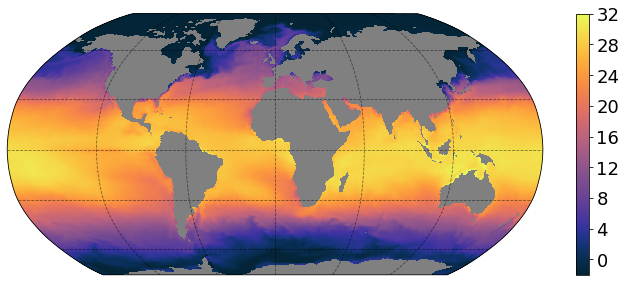

In [12]:
subplot_kws=dict(projection=ccrs.Robinson(),
                 facecolor='grey')

plt.figure(figsize=[12,8])
p = sst_plot.plot(x='geolon', y='geolat',
                  vmin=-2, vmax=32,
                  cmap=cmocean.cm.thermal,
                  subplot_kws=subplot_kws,
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False)

# add separate colorbar
cb = plt.colorbar(p, ticks=[0,4,8,12,16,20,24,28,32], shrink=0.6)
cb.ax.tick_params(labelsize=18)

p.axes.gridlines(color='black', alpha=0.5, linestyle='--')

We can also go fancy on the land background:

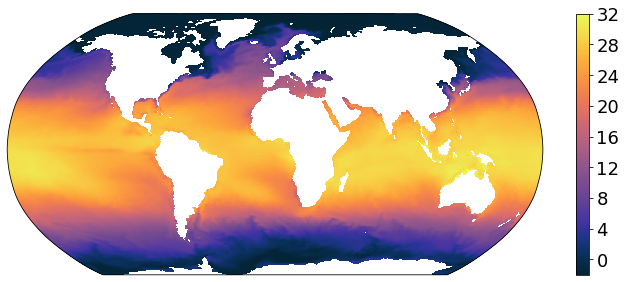

In [13]:
subplot_kws=dict(projection=ccrs.Robinson())

plt.figure(figsize=[12,8])
p = sst_plot.plot(x='geolon', y='geolat',
                  vmin=-2, vmax=32,
                  cmap=cmocean.cm.thermal,
                  subplot_kws=subplot_kws,
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False)

# add separate colorbar
cb = plt.colorbar(p, ticks=[0,4,8,12,16,20,24,28,32], shrink=0.6)
cb.ax.tick_params(labelsize=18)

# background
url = 'http://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi'
p.axes.add_wmts(url, 'BlueMarble_NextGeneration')

If you're having problem with generating plots using wmts, make sure you have the latest version of owslib (you may need to **pip uninstall owslib**,
clone [owslib source](https://github.com/geopython/OWSLib) and **python setup.py install**)
Now if you don't like the blue marble background (or other web mab service image), we can also fill the continents with a uniform color like we did before.

## Polar projections

Disclaimer: Polar projections can have some issues (especially when trying to change central longitude) but these examples are a good starting point:

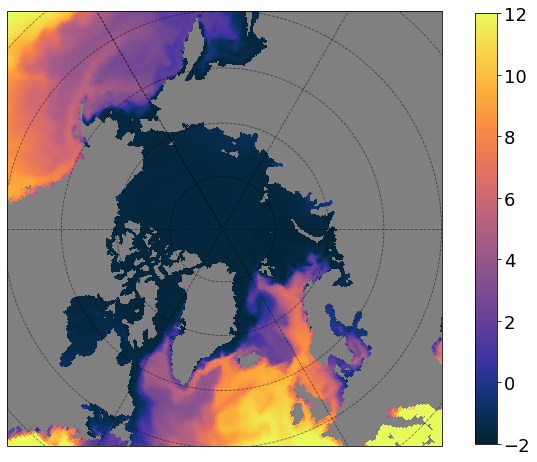

In [14]:
subplot_kws=dict(projection=ccrs.NorthPolarStereo(central_longitude=-30.0),
                 facecolor='grey')

plt.figure(figsize=[12,8])
p = sst_plot.plot(x='geolon', y='geolat',
                  vmin=-2, vmax=12,
                  cmap=cmocean.cm.thermal,
                  subplot_kws=subplot_kws,
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False)

# add separate colorbar
cb = plt.colorbar(p, ticks=[-2,0,2,4,6,8,10,12], shrink=0.99)
cb.ax.tick_params(labelsize=18)

p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
p.axes.set_extent([-300, 60, 50, 90], ccrs.PlateCarree())

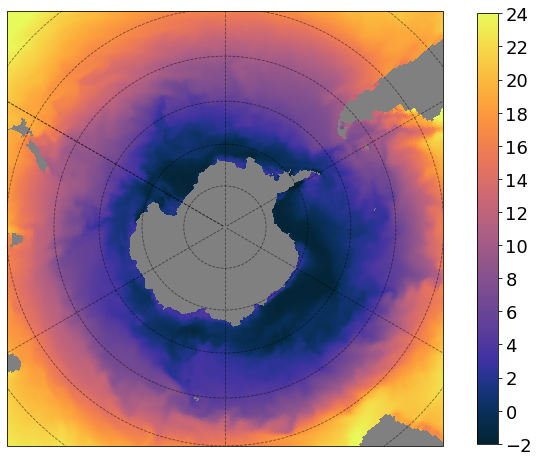

In [15]:
subplot_kws=dict(projection=ccrs.SouthPolarStereo(central_longitude=-120.),
                 facecolor='grey')

plt.figure(figsize=[12,8])
p = sst_plot.plot(x='geolon', y='geolat',
                  vmin=-2, vmax=24,
                  cmap=cmocean.cm.thermal,
                  subplot_kws=subplot_kws,
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False)

# add separate colorbar
cb = plt.colorbar(p, ticks=[-2,0,2,4,6,8,10,12,14,16,18,20,22,24], shrink=0.99)
cb.ax.tick_params(labelsize=18)

p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
p.axes.set_extent([-300, 60, -40, -90], ccrs.PlateCarree())

Now go write that paper! :)